In [29]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.datasets.samples_generator import make_regression
from sklearn.datasets.samples_generator import make_classification 
%matplotlib inline
figsize(12,4)


In [30]:
class NN(object):
    def __init__(self,parameters,learning_rate = .05):
        """expect parameters of the form ((n_input,0,0,dropout_p_0),
        (n_hidden_layer1,f_1,f_1',dropout_p_1)"""
        self.n_layers = len(parameters)
        self.sizes = [layer[0] for layer in parameters]
        self.fs = [layer[1] for layer in parameters]
        self.fprimes = [layer[2] for layer in parameters]
        self.dropout_p = [layer[3] for layer in parameters]
        self.weight_decay = 0.001
        self.learning_rate = learning_rate
        
        self.build_network()
        
    def build_network(self):
        self.weights = []
        self.biases = []
        self.inputs = []
        self.outputs = []
        self.errors = []
        self.dropout = []
        self.dropout_weights = []
        
        for layer in range(self.n_layers-1):
            n = self.sizes[layer]
            m = self.sizes[layer+1]
            
            self.weights.append(2*np.random.random((m,n))-1)
            #self.weights.append(np.random.normal(0,1,(m,n)))
 
            self.dropout_weights.append(np.zeros((m,n)))
            self.biases.append(np.random.normal(0,1,(m,1)))
            self.inputs.append(np.zeros((n,1)))
            self.outputs.append(np.zeros((n,1)))
            self.errors.append(np.zeros((n,1)))
            self.dropout.append(np.ones((n,1)))
            
        n = self.sizes[-1]
        self.inputs.append(np.zeros((n,1)))
        self.outputs.append(np.zeros((n,1)))
        self.errors.append(np.zeros((n,1)))
        self.dropout.append(np.ones((n,1))) #is this right
        
        
    def build_network_old(self):
        self.weights = []
        self.biases = []
        self.inputs = []
        self.outputs = []
        self.errors = []
        self.dropout = []
        self.dropout_weights = []
        
        #initialize weights; but not the last one (we don't need a last weight matrix)
        for layer in range(self.n_layers -1):
            #size of weight matrices
            n = self.sizes[layer] #input
            m = self.sizes[layer+1] # output
            self.weights.append(2*np.random.random((m,n))-1)

            self.dropout_weights.append(np.zeros((m,n)))
            self.biases.append(np.random.normal(0,1,(m,1)))
            self.inputs.append(np.zeros((n,1)))
            self.outputs.append(np.zeros((n,1)))
            self.errors.append(np.zeros((n,1)))
            self.dropout.append(np.ones((n,1)))
        #get input, output and error for last layer that doesn't need weight matrix    
        n = self.sizes[-1]
        self.inputs.append(np.zeros((n,1)))
        self.outputs.append(np.zeros((n,1)))
        self.errors.append(np.zeros((n,1)))
        self.dropout.append(np.ones((n,1)))

        
        
    def feedforward(self,x,dropout=False):

        k = len(x)
            
        x.shape = (k,1) # x = np.atleast_2d(x)
        self.inputs[0] = x
        self.outputs[0] = x
        if dropout == True:
            for i in range(1,self.n_layers):
                dropout = np.random.binomial(1,1-self.dropout_p[i-1],size = self.weights[i-1].shape) 
                self.inputs[i] = (self.weights[i-1]*dropout).dot(self.outputs[i-1])+self.biases[i-1]
                
        else:
            for i in range(1,self.n_layers):
                #self.inputs[i] = self.weights[i-1].dot(self.outputs[i-1]
                #                                      )+self.biases[i-1]
                
                
                
                self.inputs[i]=self.weights[i-1].dot(self.outputs[i-1]
                                                    )+self.biases[i-1]
                self.outputs[i] = self.fs[i](self.inputs[i])
        return self.outputs[-1]
    
    
     
    
    def update_weights(self,x,y,dropout=False):
        output = self.feedforward(x,dropout)
        
        self.errors[-1] = self.fprimes[-1](self.outputs[-1])*(output-y)
        
        n = self.n_layers -2

        for i in range(n,0,-1):
            self.errors[i] = self.fprimes[i](self.inputs[i]
                                 )*self.weights[i].T.dot(self.errors[i+1])
                
            self.weights[i] = self.weights[i] - self.learning_rate*np.outer(
                    self.errors[i+1],self.outputs[i])#-self.learning_rate*self.weight_decay*self.weights[i]
                    
            self.biases[i] = self.biases[i] - self.learning_rate*self.errors[i+1]
            #self.weights[0] = self.weights[0] - self.learning_rate*np.outer(self.errors[1],self.outputs[0])
            #self.biases[0] = self.biases[0] - self.learning_rate*self.errors[1]
                
        self.weights[0] = self.weights[0] - self.learning_rate*np.outer(self.errors[1],self.outputs[0])
        self.biases[0] = self.biases[0] - self.learning_rate*self.errors[1]
            
            
            

    def predict_x(self,x):
        return self.feedforward(x,False)                
                
                
    def train(self,X,y,n_iter,shuffle = True,dropout=False):
        n = X.shape[0]
        
        for repeat in range(n_iter):
            index = list(range(n))
            if shuffle ==True:
                np.random.shuffle(index)
            for row in index:
                x_i = X[row]
                y_i = y[row]
                self.update_weights(x_i,y_i,dropout)

                
    
    
    
    def predict(self,X,dropout = False):
        n = len(X)
        m = self.sizes[-1]
        
        ret = np.ones((n,m))
        for i in range(len(X)):
            ret[i,:] = self.feedforward(X[i],dropout)

        return ret
                
        
    def calculate_uncertainty(self,num_reps,X=None):
        if X == None:
            n=100
            X=np.linspace(0,3*np.pi,num=n)
            print(X)
        else:
            try:
                n = len(X)
            except:
                X = np.array([X])
                n = 1
        pred_mean = []
        pred_var = []
        for i in range(len(X)):
            safe_vals = []
            for rep in range(num_reps):
                #ret[i,:] = self.feedforward(X[i],True)
                safe_vals.append(self.feedforward(X[i],True))
            pred_mean.append(np.mean(safe_vals))#,axis=0))
            tau = 10**2*(1-max(self.dropout_p))/(2*n*self.weight_decay)
            pred_var.append(np.var(safe_vals))#,axis=0)*tau)
            
        return np.array(pred_mean),np.array(pred_var)*tau**-1
    
    
    def calc_unc(self,sample_num,X):
        try:
            n = len(X)
        except:
            X = np.array([X]) # will this work?!
            n = 1
                
            
        mean_arr = np.ones(shape=X.shape[0])
        var_arr = np.ones(shape=X.shape[0])
        for i in range(n):
            samples = []
            for j in range(sample_num):
                samples += [self.feedforward(X[i],True)]
            mean_arr[i] = np.mean(samples)
            var_arr[i] = np.var(samples)
            
        return mean_arr, var_arr

                
            

In [31]:
#@jit(nopython=True)
def logistic(x):
    return 1.0/(1+np.exp(-x))

#@jit(nopython=True)
def logistic_prime(x):
    ex=np.exp(-x)
    return ex/(1+ex)**2

#@jit(nopython=True)
def identity(x):
    return x
 
#@jit(nopython=True)
def identity_prime(x):
    return 1

#@jit(nopython=True)
def tanh(x):
    ex= np.exp(x)
    ex_neg = np.exp(-x)
    return(ex-ex_neg)/(ex+ex_neg)

#@jit(nopython=True)
def tanh_prime(x):
    ex= np.exp(x)
    ex_neg = np.exp(-x)
    return 2/(ex+ex_neg)
#expic computes logistics fast.
from scipy.special import expit

def softplus(x):
    return np.log(1+np.exp(x))

def softplus_prime(x):
    return logistic(x)


def relu(x):
    return np.log(np.max([0.000000001,x]))

def relu_prime(x):
    return np.sign(x)
param=((1,0,0),(20, expit, logistic_prime),(20, expit, logistic_prime),(1,identity, identity_prime))



In [32]:
n_features = 1
param = ((n_features,0,0,0),(12,expit,logistic_prime,0),
         (8,expit,logistic_prime,0)
         ,(1,identity,identity_prime,0))
nn = NN(param)
n=200
X=np.linspace(0,3*np.pi,num=n)
X.shape=(n,1)
y=np.sin(X)

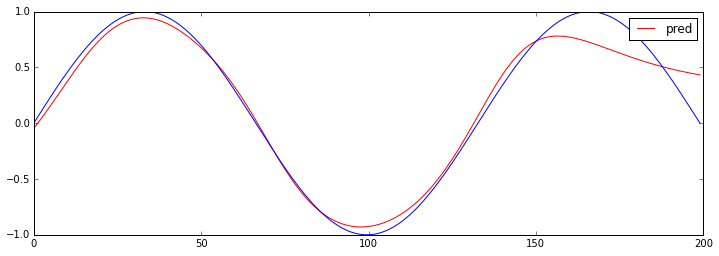

In [33]:
param=(
        #(1,0,0,.5),(20, tanh, tanh_prime,0.),
    (1,0,0,.5),(20, expit, logistic_prime,0),#######

    #(1,0,0,.5),(20, relu, relu_prime,0),
    #(1,0,0,.5),(20, softplus, softplus_prime,0),
    #   (18, softplus, softplus_prime,0.2),

      # (20, relu, relu_prime,0.1),
        #(12,tanh,tanh_prime,.3)  ,    
       (12, expit, logistic_prime,0.2),######
           #(12, expit, logistic_prime,0.1),


       #(22, expit, logistic_prime,0.),#########
           #(8, expit, logistic_prime,0.),


       (1,identity, identity_prime,0))

param=(
        #(1,0,0,.5),(20, tanh, tanh_prime,0.),
    (1,0,0,.5),(20, expit, logistic_prime,0),#######

    #(1,0,0,.5),(20, relu, relu_prime,0),
    #(1,0,0,.5),(20, softplus, softplus_prime,0),
    #   (18, softplus, softplus_prime,0.2),

      # (20, relu, relu_prime,0.1),
        #(12,tanh,tanh_prime,.3)  ,    
       (12, expit, logistic_prime,0.3),######
           #(12, expit, logistic_prime,0.1),


       #(22, expit, logistic_prime,0.),#########
           (8, expit, logistic_prime,0.1),


       (1,identity, identity_prime,0))



n=200
X=np.linspace(0,3*np.pi,num=n)
X.shape=(n,1)
y=np.sin(X)
#y+=np.random.normal(0,.1,y.shape)
mask = np.random.binomial(1,.2,n)#.as_type(bool)
mask = mask.astype(bool)
X_ = X[mask]#np.ma.masked_array(X,mask = mask)
#X_ = X_.compressed()
N=NN(param)
N.train(X,y,500,dropout=False) # now not trained on mask!

plt.plot(N.predict(X),color='r',label='pred')
#plt.plot(N_tmp.predict(X))
plt.plot(y)
plt.legend()

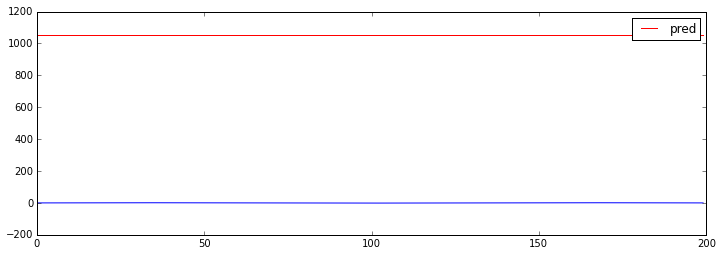

In [34]:
param=(
        #(1,0,0,.5),(20, tanh, tanh_prime,0.),
    (1,0,0,.5),(20, expit, logistic_prime,0),#######

    #(1,0,0,.5),(20, relu, relu_prime,0),
    #(1,0,0,.5),(20, softplus, softplus_prime,0),
    #   (18, softplus, softplus_prime,0.2),

      # (20, relu, relu_prime,0.1),
        #(12,tanh,tanh_prime,.3)  ,    
       (12, expit, logistic_prime,0.2),######
           #(12, expit, logistic_prime,0.1),


       #(22, expit, logistic_prime,0.),#########
           #(8, expit, logistic_prime,0.),


       (1,identity, identity_prime,0))

param=(
        #(1,0,0,.5),(20, tanh, tanh_prime,0.),
    (1,0,0,.5),(20, expit, logistic_prime,0),#######

    #(1,0,0,.5),(20, relu, relu_prime,0),
    #(1,0,0,.5),(20, softplus, softplus_prime,0),
    #   (18, softplus, softplus_prime,0.2),

      # (20, relu, relu_prime,0.1),
        #(12,tanh,tanh_prime,.3)  ,    
       (12, expit, logistic_prime,0.3),######
           #(12, expit, logistic_prime,0.1),


       #(22, expit, logistic_prime,0.),#########
           (8, expit, logistic_prime,0.1),


       (1,identity, identity_prime,0))



n=200
X=np.linspace(0,3*np.pi,num=n)
X.shape=(n,1)
y=np.sin(X)
#y+=np.random.normal(0,.1,y.shape)
mask = np.random.binomial(1,.2,n)#.as_type(bool)
mask = mask.astype(bool)
X_ = X[mask]#np.ma.masked_array(X,mask = mask)
#X_ = X_.compressed()
N=NN(param)
N.train(X,y,500,dropout=True) # now not trained on mask!

plt.plot(N.predict(X),color='r',label='pred')
#plt.plot(N_tmp.predict(X))
plt.plot(y)
plt.legend()

C:\Users\Trost\Anaconda3\lib\site-packages\ipykernel\__main__.py:159: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


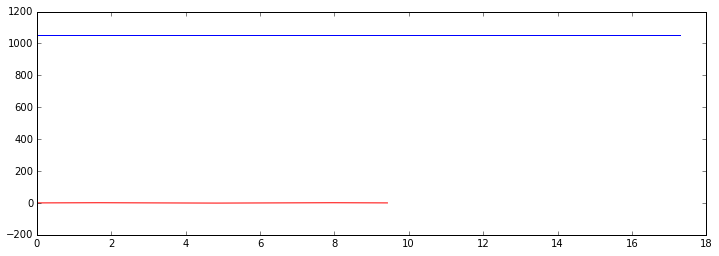

In [35]:
X_test=np.linspace(0,5.5*np.pi,num=200)
X_test.shape=(200,1)

#X_test = X
#X_test = np.atleast_2d(X_test)

#X_test = 

m,s = N.calculate_uncertainty(20,X_test)

plt.plot(X_test,m,color='cyan')
plt.plot(X_test,np.array(m)+s*10**4,color='blue')
plt.plot(X_test,m-s*10**4,color = 'blue')
plt.plot(X,y,color='red')